# Example usage

To use `pybeepop` in a project:

In [1]:
import pybeepop

print(pybeepop.__version__)

0.1.0


# Imports

In [2]:
from pybeepop.analysis import *
from pybeepop.clean_data import *
from pybeepop.eda import *
from pybeepop.to_ddl import *
import re

# Clean Data

clean the raw data into the format that is ready to be written as an SQL file

In [3]:
data1_path_origin = '../tests/data/original/average_monthly_temperature_by_state_1950-2022.parquet'
data2_path_origin = '../tests/data/original/epest_county_estimates.parquet'
data3_path_origin = '../tests/data/original/save_the_bees.parquet'
data4_path_origin = '../tests/data/original/pollution_2000_2021.parquet'

data1_path_processed = '../tests/data/processed/average_monthly_temperature_by_state_1950-2022.csv'
data2_path_processed = '../tests/data/processed/epest_county_estimates.csv'
data3_path_processed = '../tests/data/processed/save_the_bees.csv'
data4_path_processed = '../tests/data/processed/pollution_2000_2021.csv'
data_help_2_path = '../tests/data/processed/helper.csv'
data_help_path = "../tests/data/processed/helper__.csv"

data1, data2, data3, data4 = read_data(data1_path_origin, data2_path_origin, data3_path_origin, data4_path_origin)

data1 = clean_data1(data1)
data2 = clean_data2(data2)
helper = helper_dataset(data3)
data3 = clean_data3(data3, helper)
data3 = clean_data3(data3, helper)
data_help_2 = helper_dataset2(data2, data3)
data4 = clean_data4(data4)

data1.to_csv(data1_path_processed)
data2.to_csv(data2_path_processed)
data3.to_csv(data3_path_processed)
data4.to_csv(data4_path_processed)
data_help_2.to_csv(data_help_2_path)
helper.to_csv(data_help_path)

C:\Users\eric.zhao\pybeepop\src\pybeepop\clean_data.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_help_2["varroa_mites"] = "varroa_mites"


# To Data Definition Language (DDL) 

Write the .sql file, and load the file to the corresponding port and database. 

In [4]:
sql_path = "../tests/scripts/output.sql"
temperature_data_path = "../tests/data/processed/average_monthly_temperature_by_state_1950-2022.csv"
bee_data_path = "../tests/data/processed/save_the_bees.csv"
pollution_data_path = "../tests/data/processed/pollution_2000_2021.csv"
helper_data_path = "../tests/data/processed/helper.csv"
epest_data_path = "../tests/data/processed/epest_county_estimates.csv"

init_tables(sql_path)
create_sql_MonitorStation(temperature_data_path, sql_path)
create_sql_Bee(bee_data_path, sql_path)
create_sql_detect(temperature_data_path, bee_data_path, sql_path)
create_sql_GasConditions(pollution_data_path, sql_path)
create_sql_Influence(pollution_data_path, bee_data_path, sql_path)
create_sql_RiskFactors(helper_data_path, sql_path)
create_sql_Monitor(temperature_data_path, helper_data_path, sql_path)
create_sql_Kill(bee_data_path, pollution_data_path, sql_path)
create_sql_Parasite(bee_data_path, sql_path)
create_sql_Pesticide(epest_data_path, sql_path)

connection = connect_to_db(3307, 'localhost')
load_sql_to_db(connection, sql_path)

True

# Exploratory data analysis (EDA)

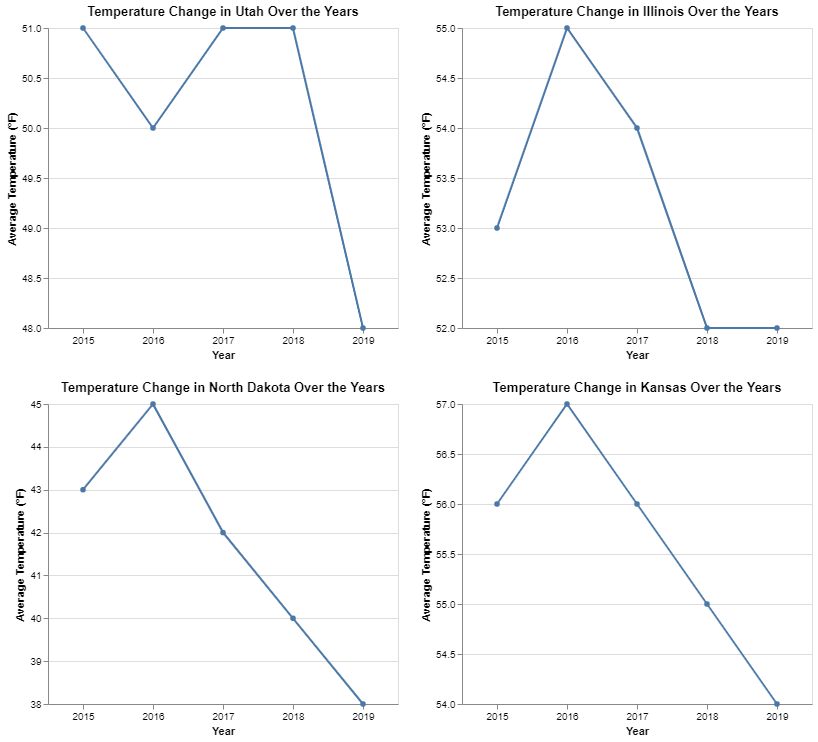

In [5]:
year_lost_path = "../tests/images/year_lost.png"
year_temperature_path = "../tests/images/year_temperature.png"
year_pesticide_path = "../tests/images/year_pesticide.png"
year_aqi_path = "../tests/images/year_aqi.png"
state_bee_loss_path = "../tests/images/state_bee_loss.png"
loss_disease_parasite_path = "../tests/images/loss_disease_parasite.png"
population_change_path =  "../tests/images/population_change.png"
temp_change_path = "../tests/images/temp_change.png"

connection = connect_to_db(3307, 'localhost')

year_percentage_lost(connection, year_lost_path)
year_temperature(connection, year_temperature_path)
year_pesticide(connection, year_pesticide_path)
year_AQI(connection, year_aqi_path)
top_ten_states_bee_loss(connection, state_bee_loss_path)

ten_states = top_ten_states(connection)

for state in ten_states:
    query_percentage_diseaselost = f"""
        SELECT Year, PercentLostByDisease
        FROM Bee
        WHERE State = '{state}'
        ORDER BY Year
    """
    years_lost, percentage_lost_by_disease = fetch_percentage_diseaselost(connection, query_percentage_diseaselost)

    query_parasite = f"""
        SELECT Year, PercentAffected
        FROM Parasite
        WHERE State = '{state}'
        ORDER BY Year
    """
    years_parasite, percentage_parasite = fetch_parasite(connection, query_parasite)

    query_colony_tracker = f"""
        SELECT Year, Colony, LostColony, AddColony
        FROM Bee
        WHERE State = '{state}'
        ORDER BY Year
    """
    colony_years, colony_values, lost_colonies, added_colonies = fetch_colony_tracker(connection, query_colony_tracker)

    query_pesticide_usage = f"""
        SELECT Year, LowEstimate, HighEstimate
        FROM Pesticide
        WHERE State = '{state}'
        ORDER BY Year
    """
    years, low_estimate, high_estimate = fetch_pesticide_usage(connection, query_pesticide_usage)

    query_aqi = f"""
        SELECT Year, Name, AverageAQI
        FROM GasConditions
        WHERE State = '{state}'
        ORDER BY Year
    """
    gas_data, aqi_data = fetch_aqi(connection, query_aqi)

    query_temperature = f"""
        SELECT m.Year, m.AverageTemperature
        FROM MonitorStation m
        JOIN Detect d ON m.CentroidLongitude = d.CentroidLongitude 
                        AND m.CentroidLatitude = d.CentroidLatitude
                        AND m.Year = d.StationYear
        WHERE d.BeeState = '{state}'
        ORDER BY m.Year
    """
    years, temperatures = fetch_temperature(connection, query_temperature)

    globals()[re.sub(r'[^a-zA-Z0-9]', '_', str(state)) + "_plot_1"] = plot_1_render(state, years_parasite, years_lost, percentage_parasite, percentage_lost_by_disease)
    globals()[re.sub(r'[^a-zA-Z0-9]', '_', str(state)) + "_plot_2"] = plot_2_render(state, colony_years, colony_values, lost_colonies, added_colonies)
    globals()[re.sub(r'[^a-zA-Z0-9]', '_', str(state)) + "_plot_3"] = plot_3_render(state, years, low_estimate, high_estimate)
    globals()[re.sub(r'[^a-zA-Z0-9]', '_', str(state)) + "_plot_4"] = plot_4_render(state, aqi_data)
    globals()[re.sub(r'[^a-zA-Z0-9]', '_', str(state)) + "_plot_5"] = plot_5_render(state, years, temperatures)

concat_plots(Illinois_plot_1, Massachusetts_plot_1, Kansas_plot_1, Georgia_plot_1, loss_disease_parasite_path)
concat_plots(Utah_plot_2, Massachusetts_plot_2, North_Dakota_plot_2, Georgia_plot_2, population_change_path)
concat_plots(Utah_plot_5, Illinois_plot_5, North_Dakota_plot_5, Kansas_plot_5, temp_change_path)

# Analysis

Mean Squared Error: 30.287219299693906
R-squared: 0.030676046553322234


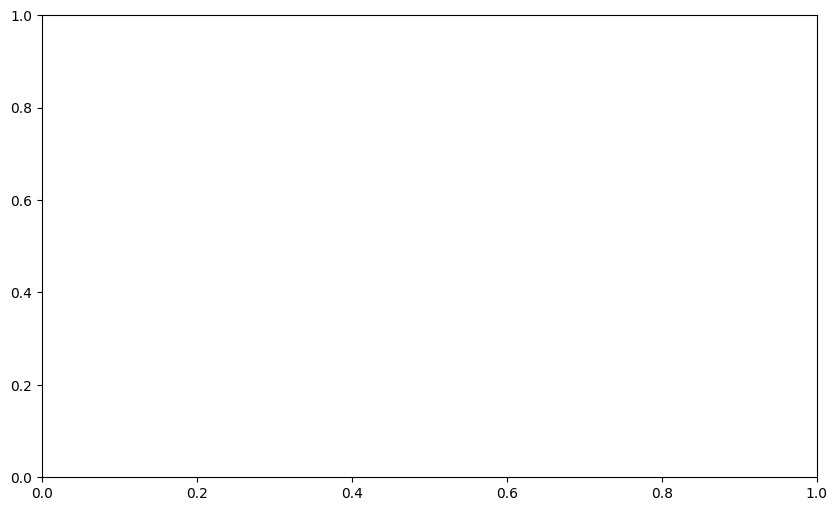

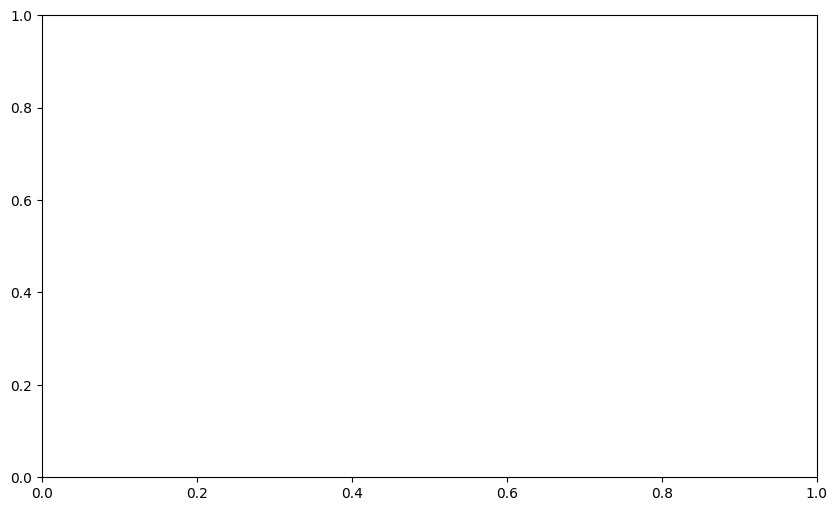

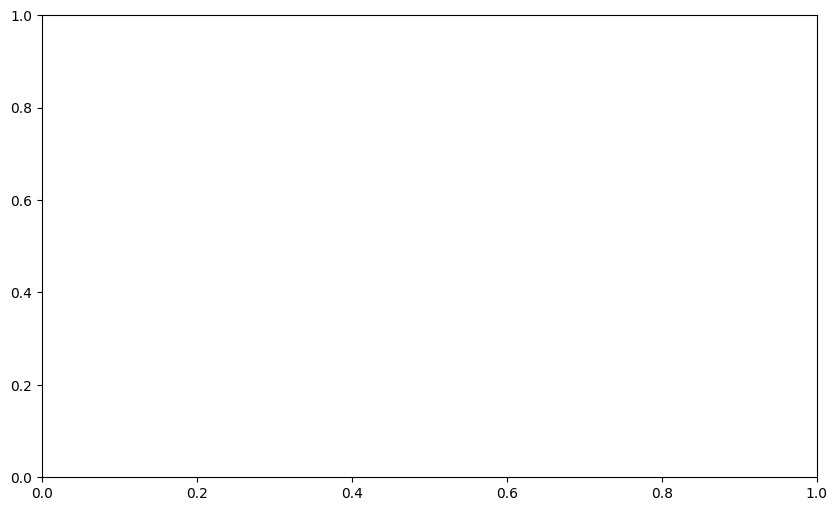

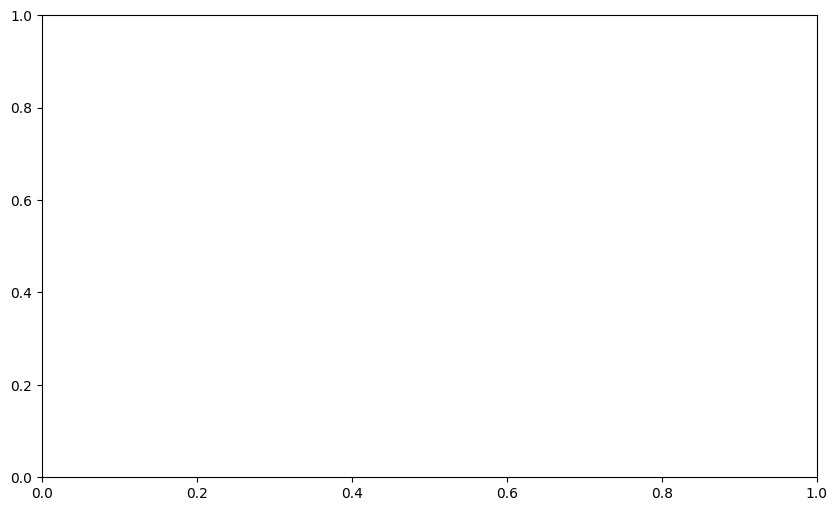

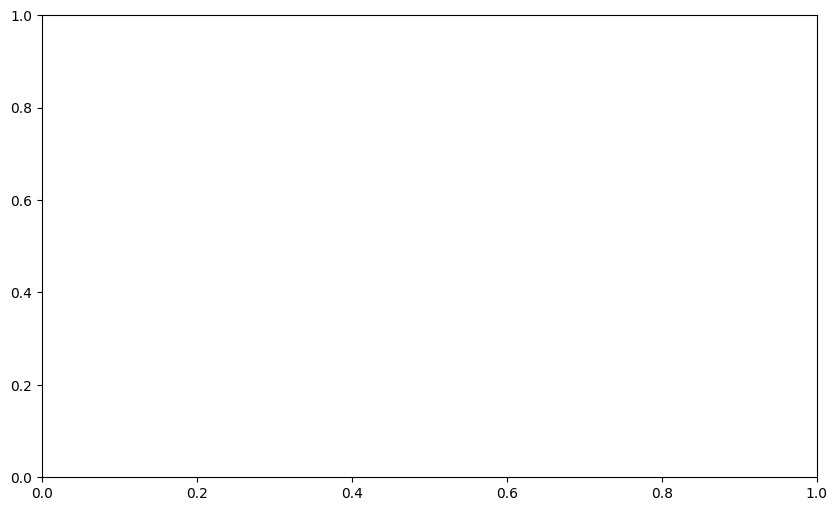

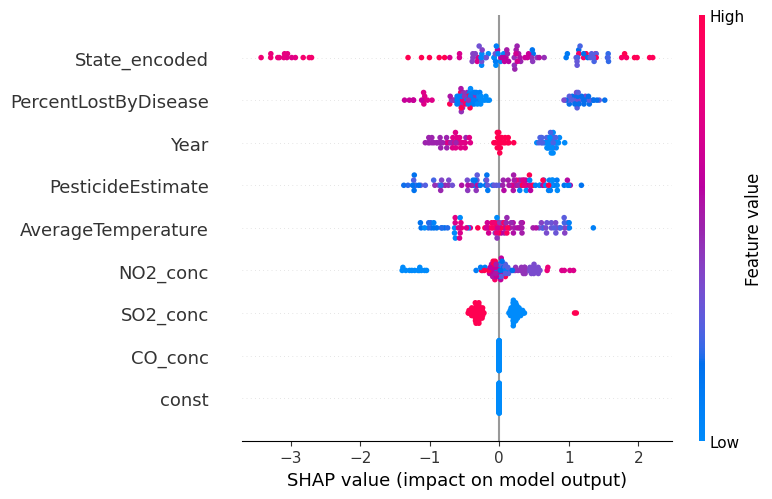

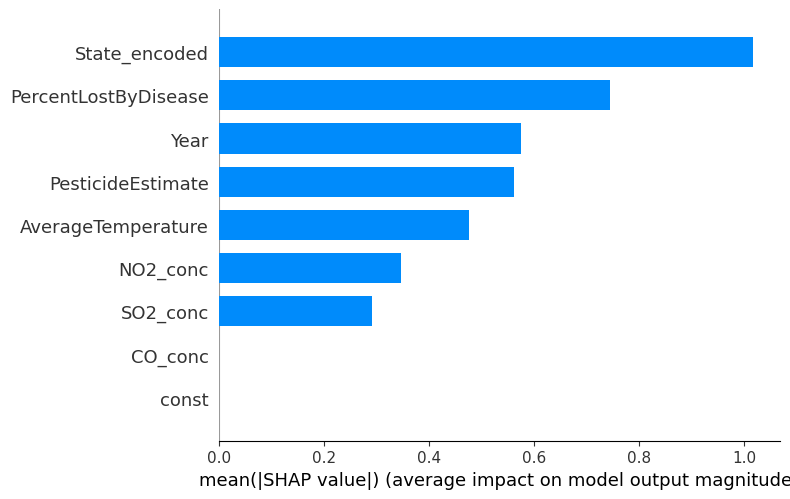

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [6]:
average_temperature_path = "../tests/images/average_temperature_linearity.png"
co_conc_path = "../tests/images/co_conc_linearity.png"
no2_conc_path = "../tests/images/no2_conc_linearity.png"
so2_conc_path = "../tests/images/so2_conc_linearity.png"
percent_lost_by_disease_path = "../tests/images/percent_lost_by_disease_linearity.png"
pesticide_estimate_path = "../tests/images/pesticide_estimate_linearity.png"
correlation_path = "../tests/images/correlation_matrix.png"
linear_model_path = "../tests/models/linear_model.pkl"
shap_train_path = "../tests/images/shap_train.png"
shap_overall_path = "../tests/images/shap_overall.png"
vif_path = "../tests/data/processed/vif.csv"


connection = connect_to_db(3307, 'localhost')

query_gas_conditions = """
    SELECT *
    FROM GasConditions 
"""
gas_conditions_df_columns = ['GasName', 'State', 'Year', 'MeanValue', 'AverageAQI']
gas_conditions_df = query_transform_dataframe(connection, query_gas_conditions, gas_conditions_df_columns)

query_bee = """
    SELECT * 
    FROM Bee
"""
columns_bee = ['State', 'Year', 'Colony', 'MaxColony', 'LostColony', 'PercentLost', 'AddColony', 'PercentRenovated', 'PercentLostByDisease']
bee_df = query_transform_dataframe(connection, query_bee, columns_bee)

query_monitor = """
    SELECT *
    FROM Monitor
"""
columns_monitor = ['CentroidLongitude', 'CentroidLatitude', 'StationYear', 'RiskFactorsReportedYear', 'RiskFactorsReportedState']
monitor_df = query_transform_dataframe(connection, query_monitor, columns_monitor)

query_monitor_station = """
    SELECT *
    FROM MonitorStation
"""
columns_monitor_station = ['CentroidLongitude', 'CentroidLatitude', 'Year', 'AverageTemperature']
monitor_station_df = query_transform_dataframe(connection, query_monitor_station, columns_monitor_station)

query_pesticide = """
    SELECT *
    FROM Pesticide
"""
columns_pesticide = ['Year', 'State', 'LowEstimate', 'HighEstimate']
pesticide_df = query_transform_dataframe(connection, query_pesticide, columns_pesticide)

combined_df = combined_dataframe(monitor_station_df, monitor_df)
temp_df = temp_dataframe(combined_df)

data = final_dataframe(temp_df, pesticide_df, gas_conditions_df, bee_df)

data["AverageTemperature"] = data["AverageTemperature"].astype(float)
data["CO_conc"] = data["CO_conc"].astype(float)
data["NO2_conc"] = data["NO2_conc"].astype(float)
data["SO2_conc"] = data["SO2_conc"].astype(float)
data["PercentLostByDisease"] = data["PercentLostByDisease"].astype(float)
data["PesticideEstimate"] = data["PesticideEstimate"].astype(float)
data["PercentLost"] = data["PercentLost"].astype(float)

check_linearity(data, 'AverageTemperature', average_temperature_path)
check_linearity(data, 'CO_conc', co_conc_path)
check_linearity(data, 'NO2_conc', no2_conc_path)
check_linearity(data, 'SO2_conc', so2_conc_path)
check_linearity(data, 'PercentLostByDisease', percent_lost_by_disease_path)
check_linearity(data, 'PesticideEstimate', pesticide_estimate_path)

vif_data = check_vif(data)
vif_data.to_csv(vif_path)

correlation(data, correlation_path)

X, y, model = linear_model(data, linear_model_path)

non_linear_model(X, y, shap_train_path, shap_overall_path)